In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier   
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import lightgbm as lgb
import matplotlib.cm as cm

# Functions for Machine Learning Models

In [80]:
def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    aucscore = roc_auc_score(y_test, preds)
    print('accuracy=', accuracy, 'precision=', precision, 'recall=', recall, 'f1=', f1score,'auc=',aucscore)
    return (accuracy, precision, recall, f1score)

def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

def sort_feature(feature_names, feature_vals):
    assert len(feature_names) == len(feature_vals)
    x_and_y = [(x, y) for x, y in zip(feature_names, feature_vals)]
    x_and_y.sort(key = lambda x: -x[1])
    return [item[0] for item in x_and_y], [item[1] for item in x_and_y]

def plot_topN_feature_importance(columns, feature_importance, title, color):
    columns, feature_importance = sort_feature(columns, feature_importance)
    plt.figure()

    x = columns; y = feature_importance
    xsum=[]; ysum=[]
    for i in range(len(y)):
        sum=0
        for j in range(i+1):
            sum=sum+y[j]
        xsum.append(i+1)
        ysum.append(sum)
        
    ysum=ysum/max(ysum)
    
    plt.scatter(xsum, ysum, c=color)
    plt.plot(xsum, ysum, c=color)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title, fontsize=18)
    plt.xlabel("Number of Top-N feature importance", fontsize=18)
    plt.ylabel("Cumulative Probability", fontsize=18)

def plot_feature_importance(columns, feature_importance, title, color):
    columns, feature_importance = sort_feature(columns, feature_importance)
    plt.figure()

    x = columns; y = feature_importance

    norm = plt.Normalize(min(y), max(y))
    norm_y = 1.2 - norm(y)
    map_vir = cm.get_cmap(name=color)
    colormp = map_vir(norm_y)

    plt.yticks(fontsize=16)
    plt.ylabel("Feature importance", fontsize=18)  
    plt.xticks(rotation=90, fontsize=16)    
    plt.bar(x[:10], y[:10], color=colormp)
    plt.title(title, fontsize=18)

# machine learning algorithms and statistic analysis set up function

In [81]:
def machine_learning(x, y, split_ratio=0.3, random_seed=28):
    x = (x - x.mean()) / x.std()    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = split_ratio, random_state = random_seed, shuffle = True)

    print("train size: {}, test size {} ".format(len(x_train), len(x_test)))

    def get_feature_importance(model):
      try:
        return model.feature_importances_
      except AttributeError:
        return None

    map = {}
    # Logistic Regression
    print("Starting Logistic Regression。。。")
    time1 = time.time()
    lr_model = LogisticRegression()
    score_train, score_test, y_predict_test = model_predict(lr_model, x_train, y_train, x_test, y_test)
    y_pred_proba = lr_model.predict_proba(x_test)[:,1]
    map['Logistic Regression'] = (score_train, score_test, get_feature_importance(lr_model), lr_model, y_test, y_pred_proba)
    print("Used time：{}s  Training score:{}  Testing score:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)

    # Naive Bayes
    print("\n Naive Bayes。。。")
    time1 = time.time()
    nb_model = GaussianNB()
    score_train, score_test, y_predict_test = model_predict(nb_model, x_train, y_train, x_test, y_test)
    y_pred_proba = nb_model.predict_proba(x_test)[:,1]
    map['Naive Bayes'] = (score_train, score_test, get_feature_importance(nb_model), nb_model, y_test, y_pred_proba)
    print("Used time：{}s  Training score:{}  Testing score:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)

    # Decision Tree
    print("\n Decision Tree。。。")
    time1 = time.time()
    dt_model = tree.DecisionTreeClassifier()
    score_train, score_test, y_predict_test = model_predict(dt_model, x_train, y_train, x_test, y_test)
    y_pred_proba = dt_model.predict_proba(x_test)[:,1]
    map['Decision Tree'] = (score_train, score_test, get_feature_importance(dt_model), dt_model, y_test, y_pred_proba)
    print("Used time：{}s  Training score:{}  Testing score:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)

    # Random Forest
    print("\n Random Forest。。。")
    time1 = time.time()
    rf_model = RandomForestClassifier()
    score_train, score_test, y_predict_test = model_predict(rf_model, x_train, y_train, x_test, y_test)
    y_pred_proba = rf_model.predict_proba(x_test)[:,1]
    map['Random Forest'] = (score_train, score_test, get_feature_importance(rf_model), rf_model, y_test, y_pred_proba)
    print("Used time：{}s  Training score:{}  Testing score:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)

    # KNN
    print("\n KNN。。。")
    time1 = time.time()
    kn_model = KNeighborsClassifier() 
    score_train, score_test, y_predict_test = model_predict(kn_model, x_train.values, y_train, x_test.values, y_test)
    y_pred_proba = kn_model.predict_proba(x_test.values)[:,1]
    map['KNN'] = (score_train, score_test, get_feature_importance(kn_model), kn_model, y_test, y_pred_proba)
    print("Used time：{}s  Training score:{}  Testing score:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)
    
    # LightGBM
    print("\n LightGBM。。。")
    time1 = time.time()
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)
    y_pred_proba = gbm.predict_proba(x_test)[:,1]
    map['LightGBM'] = (score_train, score_test, get_feature_importance(gbm), gbm, y_test, y_pred_proba)
    print("Used time：{}s  Training score:{}  Testing score:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)
    
    return map

result_map = {}

# Load dataset

In [82]:
df = pd.read_csv('df_ml.csv')
df_female = df[df['gender'] == 0]
df_male = df[df['gender'] == 1]
df.columns


Index(['bullied', 'age', 'age_grouped', 'gender', 'sexual_orientation', 'race',
       'citizen', 'physical_disability', 'learning_disability', 'activity',
       'transportation', 'grade', 'skip_class', 'income', 'student_care',
       'adult_care', 'region', 'school_type', 'religion', 'locale',
       'school_size', 'security', 'supervision', 'school_code',
       'rule_enforced', 'respect', 'banned_item'],
      dtype='object')

In [83]:
feature =  df.loc[:, ~df.columns.isin(['age_grouped', 'bullied'])].astype(float)
feature_female = df_female.loc[:, ~df_female.columns.isin(['age_grouped', 'bullied'])].astype(float)
feature_male = df_male.loc[:, ~df_male.columns.isin(['age_grouped', 'bullied'])].astype(float)
target =  df[['bullied']]
target_female = df_female[['bullied']]
target_male = df_male[['bullied']]
x, y = SMOTE().fit_resample(feature, target.values.ravel())
x_female, y_female = x[x['gender'] == 0].drop('gender', axis=1),  y[x['gender']==0]
x_male, y_male =  x[x['gender'] == 1].drop('gender', axis=1),  y[x['gender']==1]

In [84]:
#full dataset 
print('full\n')
result_map[0] = machine_learning(x, y, random_seed=1)


full

train size: 5908, test size 2532 
Starting Logistic Regression。。。
Used time：0.363034725189209s  Training score:0.6591062965470549  Testing score:0.6532385466034755
accuracy= 0.6532385466034755 precision= 0.6681222707423581 recall= 0.6057007125890737 f1= 0.6353820598006644 auc= 0.6531261640171531

 Naive Bayes。。。
Used time：0.022340059280395508s  Training score:0.6452268111035884  Testing score:0.627172195892575
accuracy= 0.627172195892575 precision= 0.6580773042616452 recall= 0.5257323832145685 f1= 0.584507042253521 auc= 0.6269323854607122

 Decision Tree。。。
Used time：0.04769396781921387s  Training score:0.9957684495599187  Testing score:0.7855450236966824
accuracy= 0.7855450236966824 precision= 0.7912621359223301 recall= 0.7743467933491687 f1= 0.7827130852340937 auc= 0.785518550338887

 Random Forest。。。
Used time：0.9176037311553955s  Training score:0.9957684495599187  Testing score:0.8495260663507109
accuracy= 0.8495260663507109 precision= 0.9075785582255084 recall= 0.77751385589

In [85]:
#female 
print('female\n')
result_map[1] = machine_learning(x_female, y_female, random_seed=1)

female

train size: 2668, test size 1144 
Starting Logistic Regression。。。


Used time：0.025610923767089844s  Training score:0.654047976011994  Testing score:0.6687062937062938
accuracy= 0.6687062937062938 precision= 0.6836283185840708 recall= 0.5669724770642202 f1= 0.6198595787362087 auc= 0.6641206291831953

 Naive Bayes。。。
Used time：0.014342308044433594s  Training score:0.6394302848575713  Testing score:0.6416083916083916
accuracy= 0.6416083916083916 precision= 0.6588235294117647 recall= 0.5137614678899083 f1= 0.5773195876288661 auc= 0.6358456755142362

 Decision Tree。。。
Used time：0.01983785629272461s  Training score:0.9970014992503748  Testing score:0.7744755244755245
accuracy= 0.7744755244755245 precision= 0.7604355716878403 recall= 0.7688073394495413 f1= 0.7645985401459854 auc= 0.7742200303257722

 Random Forest。。。
Used time：0.4992830753326416s  Training score:0.9970014992503748  Testing score:0.8435314685314685
accuracy= 0.8435314685314685 precision= 0.878099173553719 recall= 0.7798165137614679 f1= 0.8260447035957239 auc= 0.8406595089675453

 KNN。。。
Used 

In [86]:
#male
print('male\n')
result_map[2] = machine_learning(x_male, y_male, random_seed=1)

male

train size: 2685, test size 1152 
Starting Logistic Regression。。。
Used time：0.02800893783569336s  Training score:0.6521415270018622  Testing score:0.671875
accuracy= 0.671875 precision= 0.6577380952380952 recall= 0.45661157024793386 f1= 0.5390243902439024 auc= 0.6422279408125897

 Naive Bayes。。。
Used time：0.012290000915527344s  Training score:0.5854748603351956  Testing score:0.5815972222222222
accuracy= 0.5815972222222222 precision= 0.5015576323987538 recall= 0.6652892561983471 f1= 0.5719360568383659 auc= 0.5931236700153412

 Decision Tree。。。
Used time：0.02347278594970703s  Training score:0.9947858472998138  Testing score:0.7552083333333334
accuracy= 0.7552083333333334 precision= 0.7078189300411523 recall= 0.7107438016528925 f1= 0.709278350515464 auc= 0.7490844756767456

 Random Forest。。。
Used time：0.5266780853271484s  Training score:0.9947858472998138  Testing score:0.8229166666666666
accuracy= 0.8229166666666666 precision= 0.8664921465968587 recall= 0.6838842975206612 f1= 0.76

# top 10 feature importance for female

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


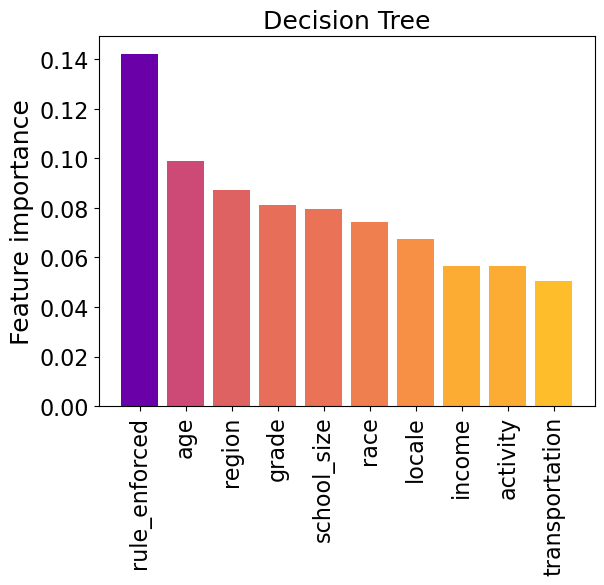

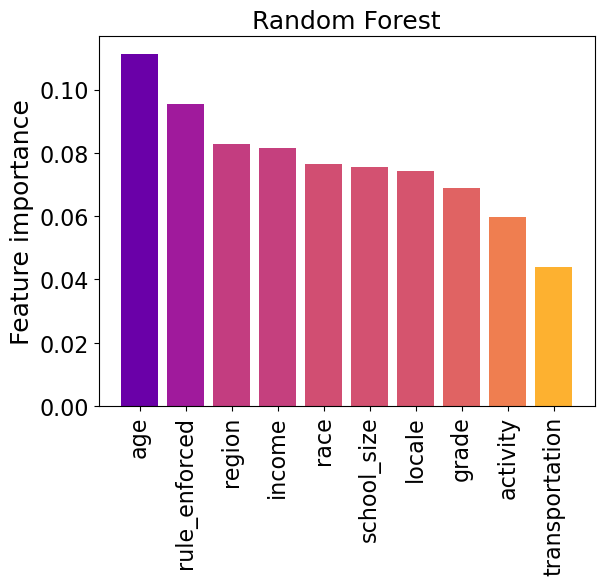

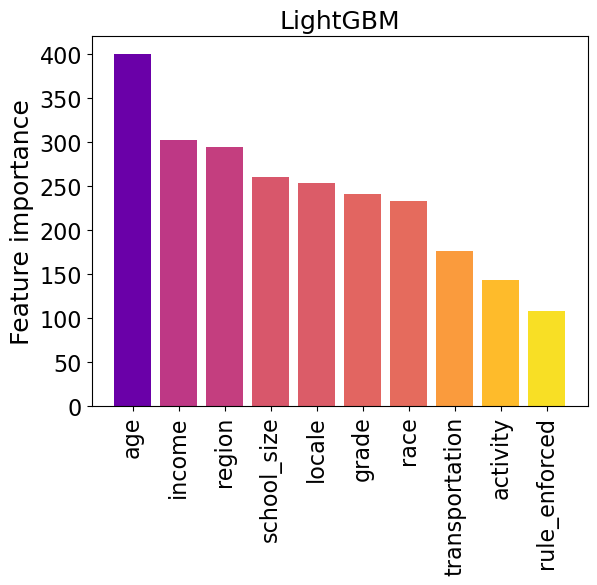

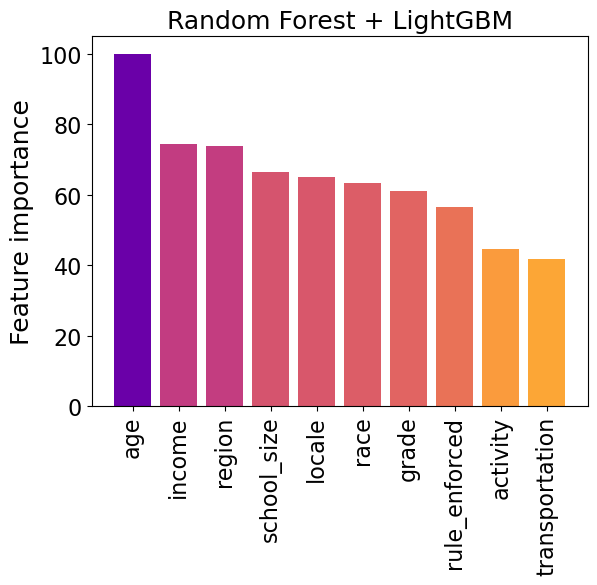

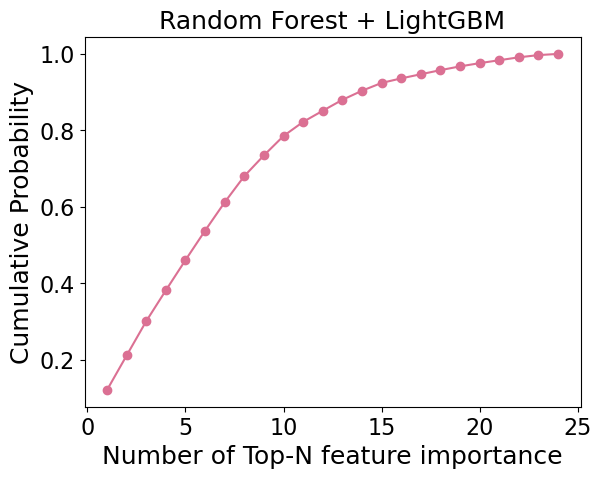

In [87]:
rfvals=[]
litgbm=[]

for model_name, vals in result_map[1].items():
    if isinstance(vals[2], np.ndarray):
        plot_feature_importance(x_female.columns, vals[2], model_name, 'plasma')
        
        if model_name == 'Random Forest':
            rfvals_max=max(vals[2])
            for i in range(len(x_female.columns)):
                rfvals.append(vals[2][i]/rfvals_max*100)
            
        if model_name == 'LightGBM':
            litgbm_max=max(vals[2])
            for i in range(len(x_female.columns)):
                litgbm.append(vals[2][i]/litgbm_max*100)
ave_rfgbm=[]
for i in range(len(x_female.columns)):
    ave_rfgbm.append((rfvals[i]+litgbm[i])/2.0)
    
plot_feature_importance(x_female.columns, ave_rfgbm, 'Random Forest + LightGBM', 'plasma')
plot_topN_feature_importance(x_female.columns, ave_rfgbm, 'Random Forest + LightGBM', 'palevioletred')

# top 10 feature importance of male 

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


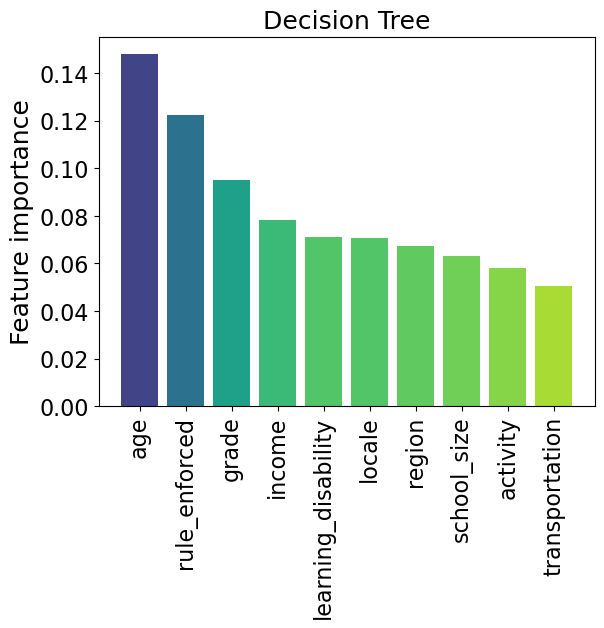

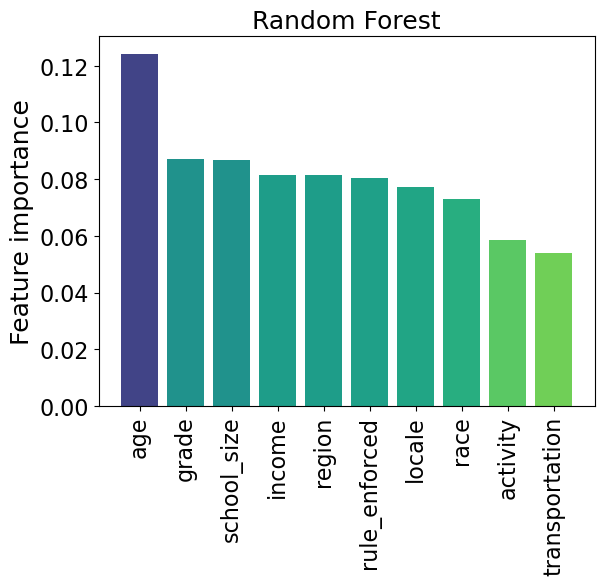

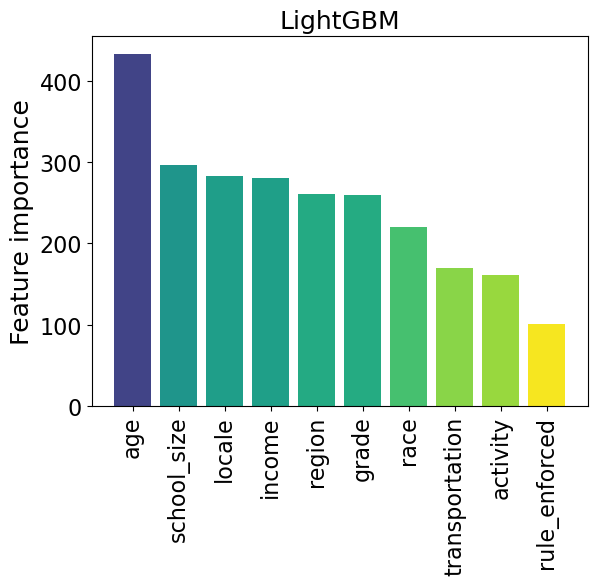

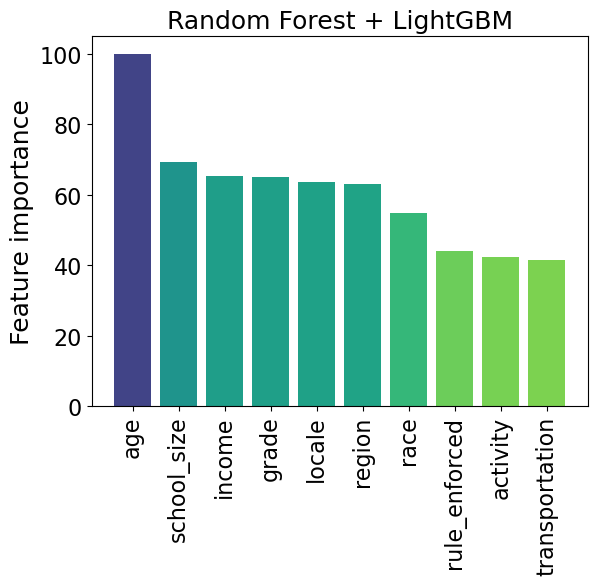

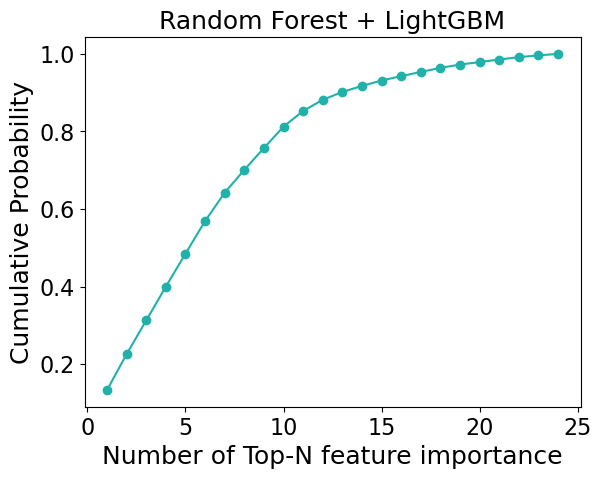

In [88]:
rfvals=[]
litgbm=[]

for model_name, vals in result_map[2].items():
    if isinstance(vals[2], np.ndarray):
        plot_feature_importance(x_male.columns, vals[2], model_name, 'viridis')
        
        if model_name == 'Random Forest':
            rfvals_max=max(vals[2])
            for i in range(len(x_male.columns)):
                rfvals.append(vals[2][i]/rfvals_max*100)
            
        if model_name == 'LightGBM':
            litgbm_max=max(vals[2])
            for i in range(len(x_male.columns)):
                litgbm.append(vals[2][i]/litgbm_max*100)
ave_rfgbm=[]
for i in range(len(x_male.columns)):
    ave_rfgbm.append((rfvals[i]+litgbm[i])/2.0)
    
plot_feature_importance(x_male.columns, ave_rfgbm, 'Random Forest + LightGBM', 'viridis')
plot_topN_feature_importance(x_male.columns, ave_rfgbm, 'Random Forest + LightGBM', 'lightseagreen')